# **2. Baseline Model**

## **2.1 Objective**
The goal of this notebook is to establish a **performance benchmark**.
* **Model:** Linear Regression (Simplest interpretable model).
* **Features:** The 25 "Nutrition & Demographics" features selected in EDA.
* **Goal:** Calculate `R²` and `MAE` (Mean Absolute Error). Any future complex model (XGBoost, etc.) must beat these numbers to be considered successful.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuration
DATA_PATH = '../data/UnifiedDataset.csv' # Adjust path if necessary

## **2.2 Data Loading & Preprocessing**
We apply the same cleaning steps identified in the EDA phase.

In [2]:
# 1. Load Data
df = pd.read_csv(DATA_PATH)

# 2. Remove Aggregates (Prevent Data Leakage)
aggregates = [
    "World", "Africa", "Americas", "Asia", "Europe", "Oceania",
    "High income countries", "Low-income countries", "Middle-income countries",
    "Upper-middle-income countries", "Lower-middle-income countries",
    "European Union", "Sub-Saharan Africa", "Latin America and the Caribbean"
]
df_clean = df[~df['Country'].isin(aggregates)].copy()

# 3. Define the 25 Features
features = [
    # Demographics
    'Gender', '% Population Aged 0-14', '% Population Aged 15-64', '% Population Aged 65+',
    # Macronutrients
    'Diet Calories Fat', 'Diet Calories Carbohydrates', 'Diet Calories Animal Protein', 'Diet Calories Plant Protein',
    # Diet Composition
    'Diet Composition Sugar', 'Diet Composition Oils And Fats', 'Diet Composition Meat',
    'Diet Composition Dairy And Eggs', 'Diet Composition Fruit And Vegetables',
    'Diet Composition Starchy Roots', 'Diet Composition Pulses', 'Diet Composition Cereals And Grains',
    'Diet Composition Alcoholic Beverages', 'Diet Composition Other',
    # Consumption
    'Vegetable Consumption', 'Cereal Consumption Wheat', 'Cereal Consumption Rice',
    'Fruit Consumption Bananas', 'Fruit Consumption Oranges And Mandarines',
    'Fruit Consumption Apples', 'Fruit Consumption Lemons And Limes'
]
target = '% Death Cardiovascular'

# 4. Encoding & Handling Missing Values
# Encode Gender
le = LabelEncoder()
df_clean['Gender'] = df_clean['Gender'].astype(str)
df_clean['Gender'] = le.fit_transform(df_clean['Gender'])

# Create Modeling DataFrame
df_model = df_clean[features + [target]].copy()
df_model = df_model.dropna()

print(f"Baseline Training Data: {df_model.shape[0]} rows")

Baseline Training Data: 5976 rows


## **2.3 Model Training**
We use a standard 80/20 train-test split.

In [3]:
X = df_model[features]
y = df_model[target]

# Split: 80% Train, 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize & Train Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

## **2.4 Evaluation (The Benchmark Scores)**

--------------------------------------
BASELINE MODEL RESULTS
--------------------------------------
MAE (Mean Absolute Error): 5.0517
RMSE (Root Mean Sq Error): 6.4282
R² Score (Test Set):       0.5022
--------------------------------------


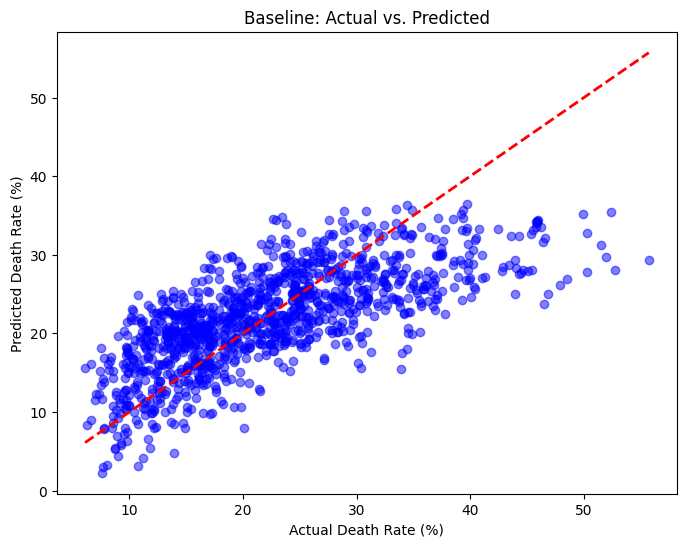

In [4]:
# Calculate Metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"--------------------------------------")
print(f"BASELINE MODEL RESULTS")
print(f"--------------------------------------")
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"RMSE (Root Mean Sq Error): {rmse:.4f}")
print(f"R² Score (Test Set):       {r2:.4f}")
print(f"--------------------------------------")

# Visualizing Predictions vs Reality
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Death Rate (%)')
plt.ylabel('Predicted Death Rate (%)')
plt.title('Baseline: Actual vs. Predicted')
plt.show()

## **2.5 Baseline Docs (Findings)**


### **1. Model Performance**
* **R² Score:** The model explains approximately **0.5022%** (check output) of the variance in death rates.
* **Error:** On average, the model is off by **5.0517%** (MAE) when predicting the cardiovascular death rate.

### **2. Interpreting the Coefficients (The "Linear" View)**
Let's look at how this simple model views our features. Does it show the "Wealth Paradox" (e.g., Sugar being good)?

/tmp/ipython-input-1767982549.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=top_coefs, palette='coolwarm')


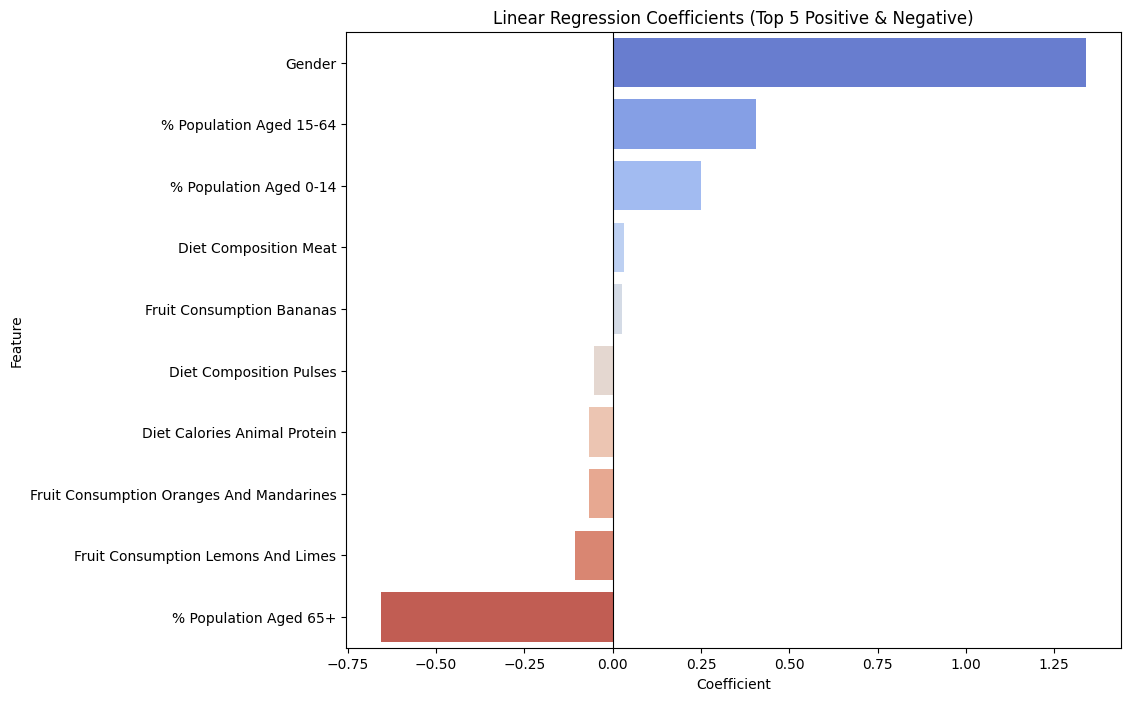

In [5]:
# Create a DataFrame of Coefficients
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

# Visualize Top Positive & Negative Coefficients
plt.figure(figsize=(10, 8))
top_coefs = pd.concat([coef_df.head(5), coef_df.tail(5)])
sns.barplot(x='Coefficient', y='Feature', data=top_coefs, palette='coolwarm')
plt.title('Linear Regression Coefficients (Top 5 Positive & Negative)')
plt.axvline(0, color='black', linewidth=0.8)
plt.show()

### **3. Why we need Feature Engineering & Non-Linear Models**
* **Linear Limitation:** This model assumes that "More Wheat" always equals "More Death" (or less) linearly. It cannot capture "Goldilocks" zones (where moderate consumption is healthy, but high is bad).
* **Confounds:** As seen in the coefficients, factors like Sugar might have negative weights due to correlation with GDP (Wealthier countries eat more sugar but have better hospitals).

**Next Step:** In `FEATURE_ENG.ipynb`, we will create interaction terms (like Sugar * Fat) to help the model understand these complex relationships better.